# Phon.py

In [1]:
from ase import Atoms
from ase.calculators.mixing import SumCalculator
from ase.io import read, write
from calorine.calculators import CPUNEP
from calorine.tools import relax_structure
from dftd3.ase import DFTD3
from hiphive import ForceConstantPotential
from matplotlib import pyplot as plt
from phonopy.api_gruneisen import PhonopyGruneisen
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.units import THzToCm
import numpy as np
import os
import pandas as pd
import phonopy
import scienceplots
import seekpath
import subprocess
import sys
import warnings

plt.style.use(['science','ieee','no-latex','bright'])
warnings.filterwarnings('ignore')

In [2]:
class Phonbycalorine:
    def __init__(self, nep_path="./nep.txt", use_dftd3=False):
        """
        初始化 Phonbycalorine 类实例
        """
        self.nep_path = nep_path
        self.use_dftd3 = use_dftd3

    def nep_calculator(self):
        """
        配置NEP计算器，若需色散校正，则use_dftd3=True
        """
        if os.path.exists(self.nep_path):
            if self.use_dftd3:
                return SumCalculator([CPUNEP(self.nep_path), DFTD3(method="pbe", damping="d3bj")])
            return CPUNEP(self.nep_path)
        print(f"File {self.nep_path} does not exist.")
        sys.exit(1)
            
    def calculate_forces_by_nep(self, structure):    
        """
        使用NEP计算结构的原子受力
        """
        structure.calc = self.nep_calculator()
        return structure.get_forces().copy()
    
    def calculate_force_constants_by_dft(self, structure, primitive_matrix, supercell_matrix, unitcell_filename="POSCAR"):
        """
        加载并返回DFT计算的力常数
        """
        if os.path.exists("FORCE_SETS") or os.path.exists("FORCE_CONSTANTS"):
            phonon = phonopy.load(supercell_matrix=supercell_matrix, primitive_matrix=primitive_matrix, unitcell_filename=unitcell_filename)
            return phonon
        print("The file FORCE_SETS or FORCE_CONSTANTS does not exist.")
        return None

    def calculate_force_constants_by_nep(self, structure, primitive_matrix, supercell_matrix, fmax=0.0001, distance=0.01):    
        """
        使用NEP计算力常数
        """
        structure.calc = self.nep_calculator()
        relax_structure(structure, fmax=fmax)
        phonopy_atoms = PhonopyAtoms(
            symbols=structure.symbols, 
            cell=structure.cell, 
            scaled_positions=structure.get_scaled_positions(), 
            pbc=[True, True, True]
        )
        phonon = phonopy.Phonopy(phonopy_atoms, supercell_matrix, primitive_matrix)
        phonon.generate_displacements(distance=distance)
        
        forces = []
        for phonopy_supercell in phonon.supercells_with_displacements:
            structure_ase = Atoms(
                symbols=phonopy_supercell.symbols, 
                cell=phonopy_supercell.cell, 
                scaled_positions=phonopy_supercell.scaled_positions, 
                pbc=[True, True, True]
            )
            forces.append(self.calculate_forces_by_nep(structure_ase))
        
        phonon.forces = forces
        phonon.produce_force_constants()
        phonon.set_force_constants_zero_with_radius(cutoff_radius=20)
        # phonon.save(settings={'force_constants': True})
        return phonon
        
    def get_kpoints(self, structure):
        """
        生成k点路径
        """
        structure_tuple = (structure.cell, structure.get_scaled_positions(), structure.numbers)
        path = seekpath.get_explicit_k_path(structure_tuple)
        
        kpoints_rel, kpoints_lincoord, labels = path['explicit_kpoints_rel'], path['explicit_kpoints_linearcoord'], path['explicit_kpoints_labels']
        labels = ['$\Gamma$' if label == 'GAMMA' else label for label in labels]
        labels = [label.replace('_', '$_') + '$' if '_' in label else label for label in labels]
        
        return kpoints_rel, kpoints_lincoord, labels
    
    def get_manual_kpoints(self, structure, high_symmetry_points, num=30):
        """
        基于手动定义的高对称点生成k点路径
        high_symmetry_points: 包含点坐标和标签的列表
        例如：[{'label': 'X', 'coords': [0.5, 0.0, 0.5]}, {'label': 'L', 'coords': [0.5, 0.5, 0.5]}]
        """
        kpoints_rel, kpoints_lincoord, labels = [], [], []
        current_distance = 0
        
        for i, point in enumerate(high_symmetry_points[:-1]):
            start, end = np.array(point['coords']), np.array(high_symmetry_points[i + 1]['coords'])
            kpoint_segment = np.linspace(start, end, num=num)
            kpoints_rel.extend(kpoint_segment)
            
            segment_length = np.linalg.norm(end - start)
            kpoints_lincoord.extend(np.linspace(current_distance, current_distance + segment_length, num=num))
            
            current_distance += segment_length
            labels.extend([point['label']] + [''] * (num-1))
            if i == len(high_symmetry_points) - 2:
                labels[-1] = high_symmetry_points[i + 1]['label']
            labels = ['$\Gamma$' if label == 'GAMMA' else label for label in labels]
        
        return kpoints_rel, kpoints_lincoord, labels
    
    def create_phonon_dataframe(self, phonon, kpoints_rel, kpoints_lincoord):
        """
        生成声子数据的DataFrame
        """
        phonon.run_band_structure([kpoints_rel], with_eigenvectors=True, with_group_velocities=True)
        band_structure = phonon.get_band_structure_dict()
        
        df = pd.DataFrame(band_structure['frequencies'][0], index=kpoints_lincoord)
        return df
        
    def calculate_dos(self, phonon):
        """
        计算声子态密度
        """
        phonon.run_mesh([20, 20, 20], is_mesh_symmetry=False, with_eigenvectors=False, with_group_velocities=False, is_gamma_center=False) 
        phonon.run_total_dos(sigma=0.05, freq_min=None, freq_max=None, freq_pitch=None, use_tetrahedron_method=False)
        dos = phonon.get_total_dos_dict()
        return dos

    def _plot_a_band(self, ax, df, **kwargs):
        """
        绘制一组声子色散曲线。
        """
        label = kwargs.pop('label', None)
        for i, col in enumerate(df.columns):
            ax.plot(df.index, df[col], label=label if i == 0 else None, **kwargs)
        
    def _plot_a_dos(self, ax, phonon, **kwargs):
        """
        绘制一组声子色散曲线对应的态密度曲线。
        """   
        label = kwargs.pop('label', None)
        dos = self.calculate_dos(phonon)
        ax.plot(dos['frequency_points'], dos['total_dos'], label=label, **kwargs)
    
    def _plot_band_and_dos(self, ax1, ax2, df, phonon, **kwargs):
        """
        绘制一组声子色散曲线及其对应的态密度曲线。
        """
        label = kwargs.pop('label', None)
        
        for i, col in enumerate(df.columns):
            ax1.plot(df.index, df[col], label=label if i == 0 else None, **kwargs)
            
        dos = self.calculate_dos(phonon)
        ax2.plot(dos['total_dos'], dos['frequency_points'], label=label, **kwargs)

    def plot_phonon_dispersion(self, kpoints_rel, kpoints_lincoord, labels, phonons, filename, custom_styles=None):
        """
        绘制声子色散。
        """
        fig, ax = plt.subplots()
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
        for i, (label, phonon) in enumerate(phonons.items()):
            default_style = {
                'color': f'C{i}', 
                'ls': '-',
                'lw': 1.0,
                'label': label,
            }
            if custom_styles and label in custom_styles:
                default_style.update(custom_styles[label])
            df = self.create_phonon_dataframe(phonon, kpoints_rel, kpoints_lincoord)
            self._plot_a_band(ax, df, **default_style)
    
        df_path = pd.DataFrame(dict(labels=labels, positions=kpoints_lincoord))
        df_path = df_path[df_path.labels != '']
        
        for xp in df_path.positions:
            ax.axvline(xp, c='black', lw=0.5)
        ax.axhline(y=0.0, c='black', lw=0.5)
    
        ax.set_xlabel('KPATH')
        ax.set_ylabel('Frequency (THz)')
        ax.set_xlim(df.index.min(), df.index.max())
        ax.set_xticks(df_path.positions)
        ax.set_xticklabels(df_path.labels)
        ax.legend(loc="upper right", fontsize=plt.rcParams['font.size'] - 2)
    
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
    
    def plot_phonon_dos(self, phonons, filename, custom_styles=None):    
        """
        绘制声子态密度图
        """
        fig, ax = plt.subplots()
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
        for i, (label, phonon) in enumerate(phonons.items()):
            default_style = {
                'color': f'C{i}', 
                'ls': '-',
                'lw': 1.0,
                'label': label,
            }
            if custom_styles and label in custom_styles:
                default_style.update(custom_styles[label])
            self._plot_a_dos(ax, phonon, **default_style)
        
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('DOS')
        ax.legend(loc="upper right", fontsize=plt.rcParams['font.size'] - 2)
        
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
    
    def plot_phonon_dispersion_and_dos(self, kpoints_rel, kpoints_lincoord, labels, phonons, filename, custom_styles=None):
        """
        绘制声子色散图（左边）和声子态密度图（右边），两个图共用一个 y 轴。
        custom_styles: dict, 每个键对应一个 phonon 的绘图样式。
        """
        fig, (ax1, ax2) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(3.5, 1.8)) 
        
        df_path = pd.DataFrame(dict(labels=labels, positions=kpoints_lincoord))
        df_path = df_path[df_path.labels != '']

        xp_list = []
        for xp in df_path.positions:
            if xp in xp_list:
                continue
            else:
                xp_list.append(xp)
                ax1.axvline(xp, c='black', lw=0.5)
    
        for i, (label, phonon) in enumerate(phonons.items()):
            default_style = {
                'color': f'C{i}', 
                'ls': '-',
                'lw': 1.0,
                'label': label,
            }
            if custom_styles and label in custom_styles:
                default_style.update(custom_styles[label])
            df = self.create_phonon_dataframe(phonon, kpoints_rel, kpoints_lincoord)
            self._plot_band_and_dos(ax1, ax2, df, phonon, **default_style)

        ax1.set_xlabel('KPATH')
        ax1.set_ylabel('Frequency (THz)')
        ax1.set_xlim(df.index.min(), df.index.max())
        ax1.set_xticks(df_path.positions)
        ax1.set_xticklabels(df_path.labels)
        ax1.tick_params(axis='both', which='minor', length=0)
        # ax1.legend(loc="best", fontsize=plt.rcParams['font.size'] - 4, frameon=False)
    
        ax2.set_xlabel('DOS')
        ax2.set_ylabel(None)
        ax2.set_xlim(0, None)
        y_min, y_max = ax1.get_ylim()
        ax2.set_ylim(y_min, y_max)
        ax2.tick_params(axis='both', which='minor', length=0)
        ax2.legend(loc="best", fontsize=plt.rcParams['font.size'] - 4, frameon=False)
    
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight') 

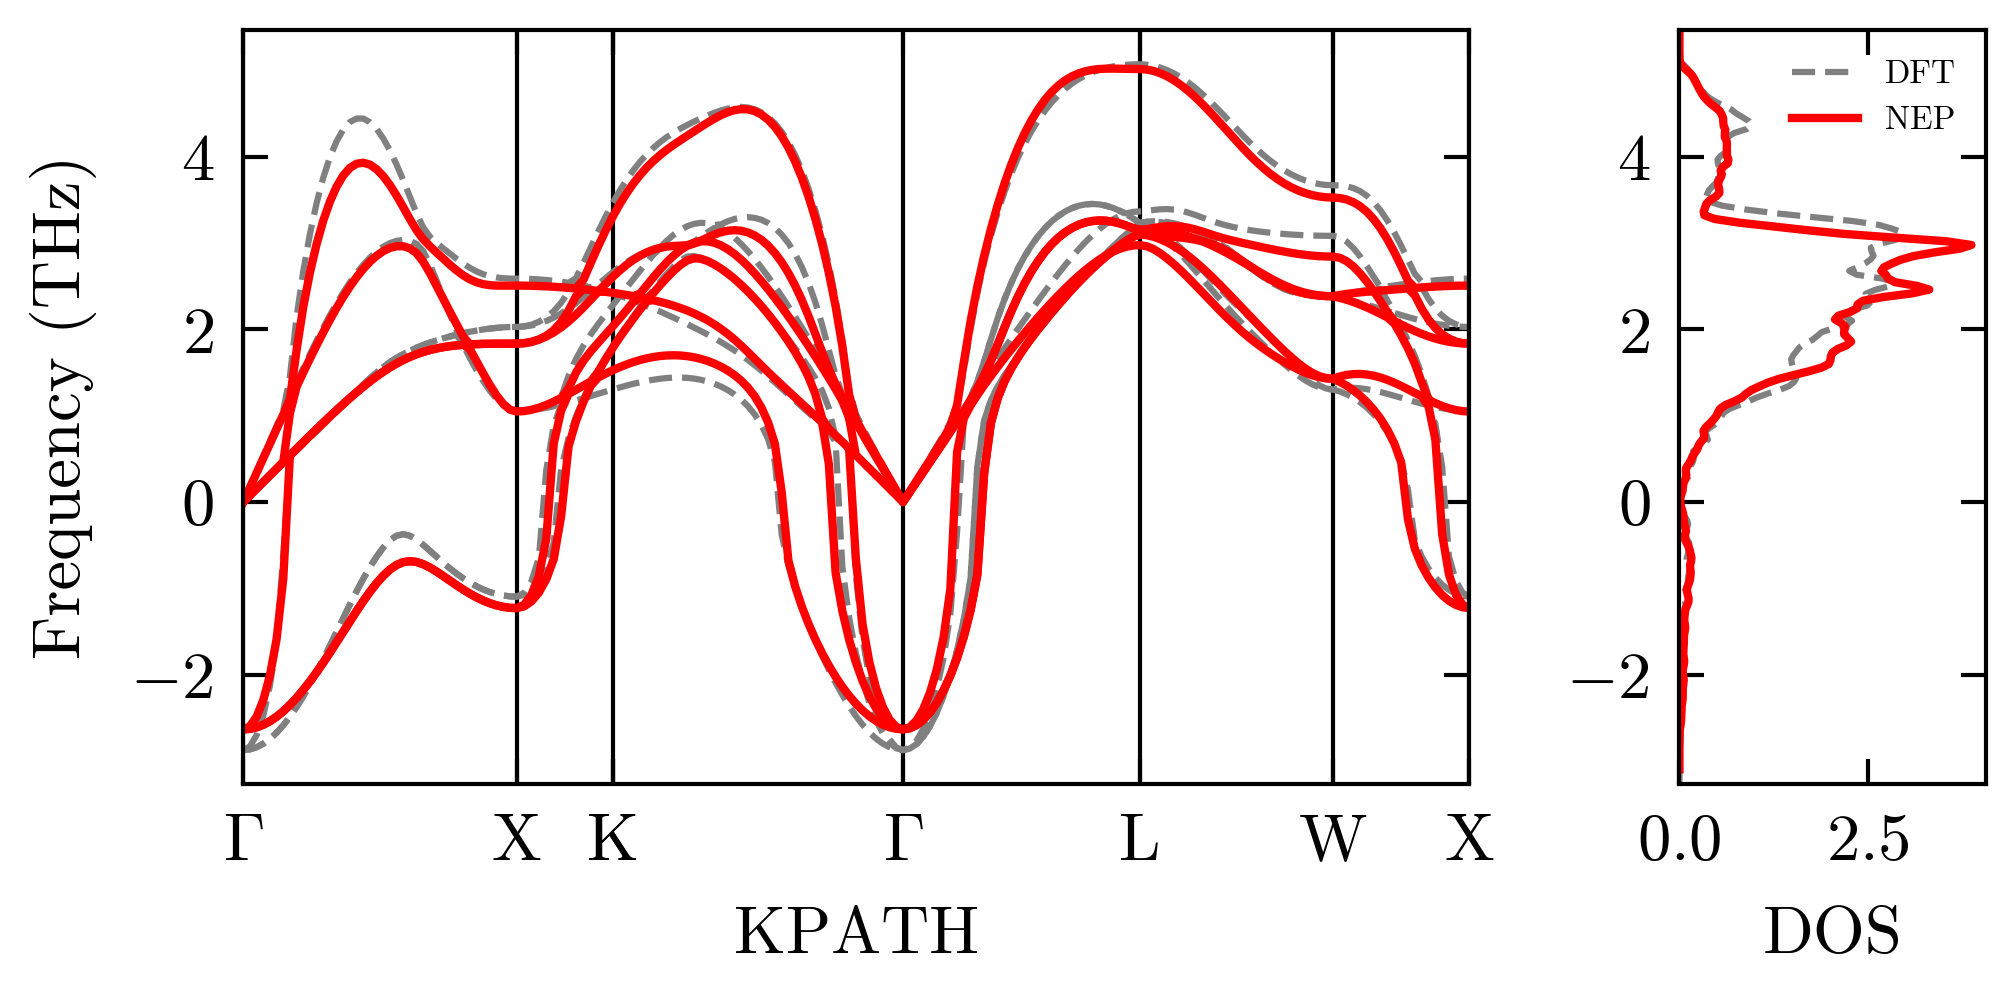

In [3]:
unit_cell = read("./POSCAR")
primitive_matrix = 'auto'
supercell_matrix = [[3, 0, 0], 
                    [0, 3, 0], 
                    [0, 0, 3]]

# high_symmetry_points = [
#     {'label': 'L', 'coords': [0.5, 0.5, 0.5]},
#     {'label': 'GAMMA', 'coords': [0.0, 0.0, 0.0]},
#     {'label': 'X', 'coords': [0.5, 0.0, 0.5]},
# ]

phonons = dict() 
pc = Phonbycalorine(nep_path='./nep_force_delta_generation500000.txt')
phonons["DFT"] = pc.calculate_force_constants_by_dft(unit_cell, primitive_matrix, supercell_matrix)
phonons["NEP"] = pc.calculate_force_constants_by_nep(unit_cell, primitive_matrix, supercell_matrix)

# kpoints_rel, kpoints_lincoord, labels = pc.get_manual_kpoints(unit_cell, high_symmetry_points)
kpoints_rel, kpoints_lincoord, labels = pc.get_kpoints(unit_cell)
# for i in range(len(labels)):
#     if labels[i] != '':
#         print(labels[i], kpoints_rel[i])

custom_styles = {
    "DFT": {"color": "grey", "ls": "--", "lw": 0.75, "label": "DFT"},
    "NEP": {"color": "red", "ls": "-", "lw": 1.0, "label": "NEP"}
}
pc.plot_phonon_dispersion_and_dos(kpoints_rel, kpoints_lincoord, labels, phonons, "phon.png", custom_styles=custom_styles)
# pc.plot_phonon_dispersion(kpoints_rel, kpoints_lincoord, labels, phonons, filename="phonon_dispersion.png", custom_styles=custom_styles)
# pc.plot_phonon_dos(phonons, filename="phonon_dos.png", custom_styles=custom_styles)

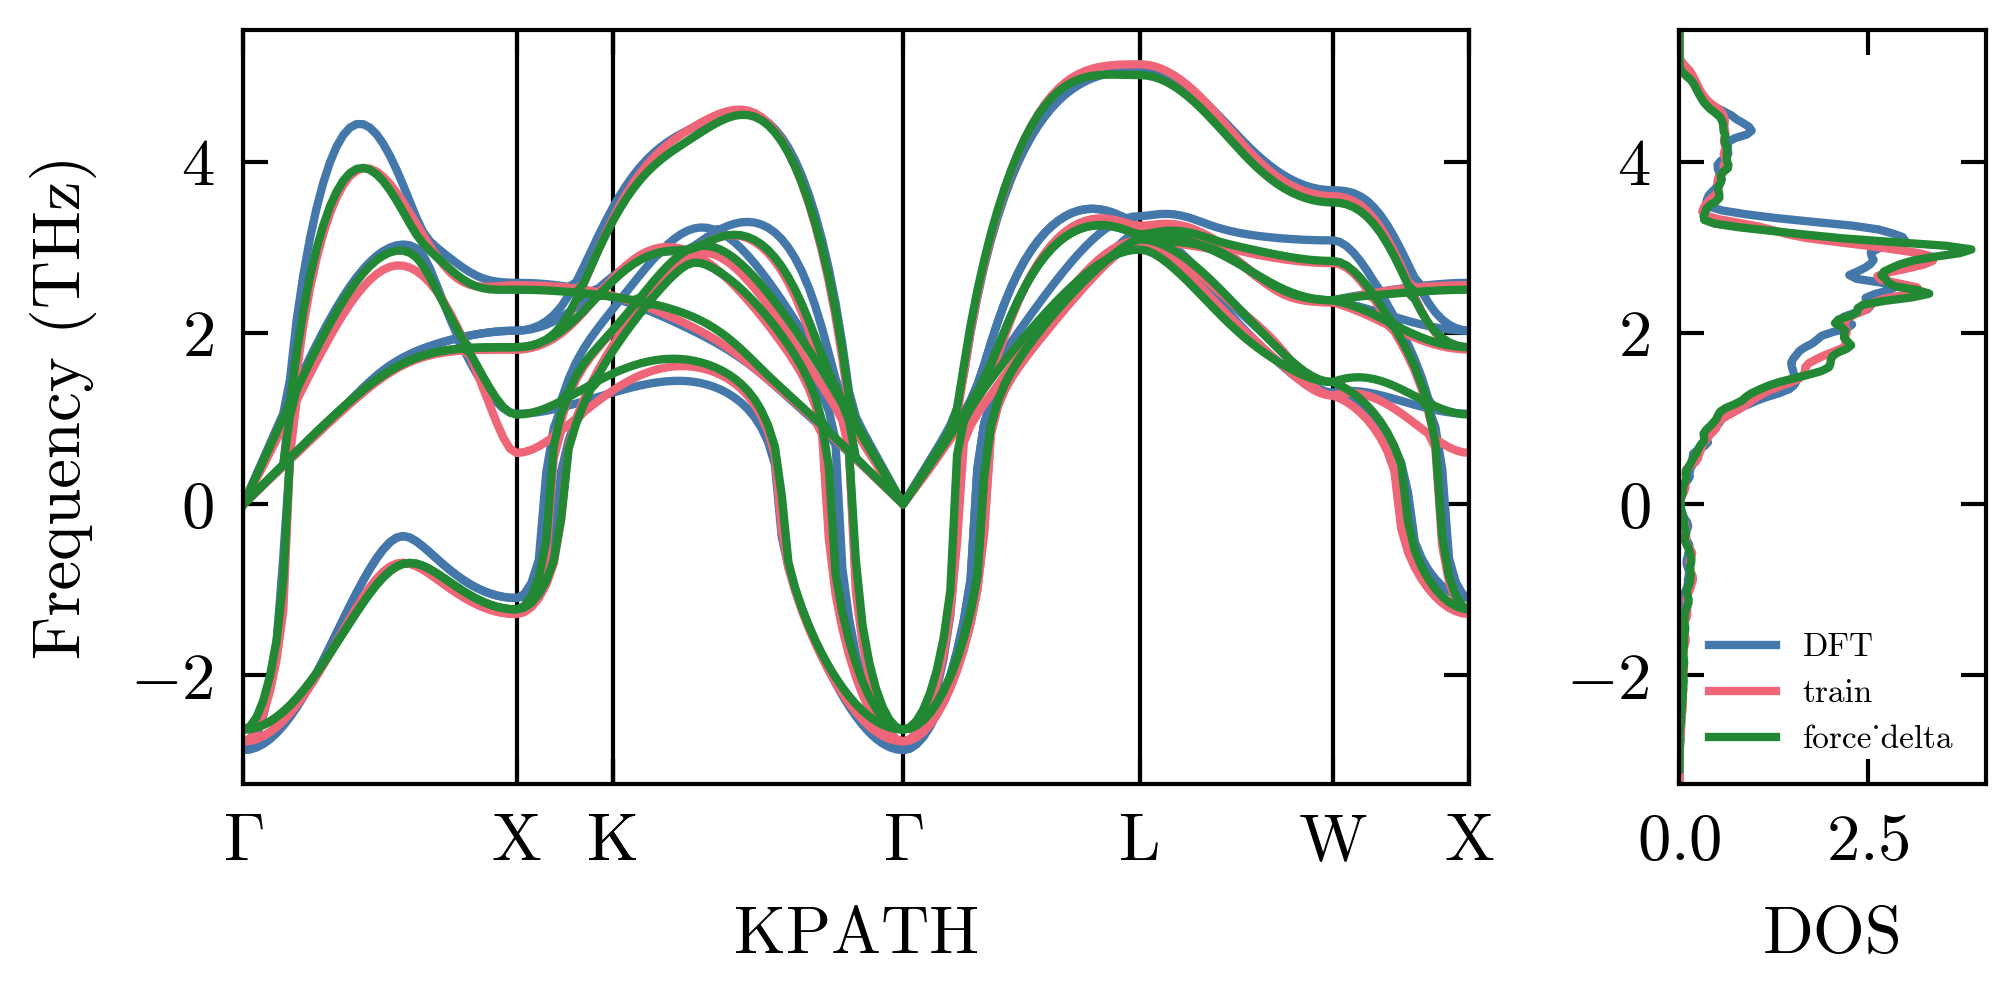

In [4]:
phonons = dict() 

pc = Phonbycalorine()
phonons["DFT"] = pc.calculate_force_constants_by_dft(unit_cell, primitive_matrix, supercell_matrix)

pc = Phonbycalorine(nep_path='./nep_generation500000.txt')
phonons["train"] = pc.calculate_force_constants_by_nep(unit_cell, primitive_matrix, supercell_matrix)

pc = Phonbycalorine(nep_path='./nep_force_delta_generation500000.txt')
phonons["force_delta"] = pc.calculate_force_constants_by_nep(unit_cell, primitive_matrix, supercell_matrix)

kpoints_rel, kpoints_lincoord, labels = pc.get_kpoints(unit_cell)

pc.plot_phonon_dispersion_and_dos(kpoints_rel, kpoints_lincoord, labels, phonons, "test.png")